In [1]:
import sys
sys.path = ['',
 '/cm/shared/sw/pkg-old/devel/python2/2.7.13/bin',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python27.zip',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/plat-linux2',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-tk',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-old',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-dynload',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages/IPython/extensions',
 '/mnt/home/llevasseur/.ipython']

In [2]:
import tensorflow as tf
import numpy as np

tf.enable_eager_execution()

/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [85]:
execfile("AE_RIM_definitions.py")

train_batch_size = 10
npix_side = 512

# checkpoint_path_1 = "checkpoints/model1_512"
# checkpoint_path_2 = "checkpoints/model2_512"


import matplotlib.pyplot as plt
%matplotlib inline  
from IPython import display
import pylab as pl

In [87]:
src_side = 20.48/2
im_side = 20.48

sk_gen = SRC_KAPPA_Generator(train_batch_size=train_batch_size,test_batch_size=train_batch_size,kap_side_length=im_side, num_src_side=npix_side,num_kappa_side=npix_side,src_side=src_side)
lens_util_obj = lens_util(im_side= im_side, src_side=src_side, numpix_side = npix_side ,kap_side=im_side,  method = "Unet")


noise_rms = 0.01
sk_gen.draw_k_s("test")

# RESTORE=False
# if (RESTORE):
#     RIM.model_1.load_weights(checkpoint_path_1)
#     RIM.model_2.load_weights(checkpoint_path_2)

In [76]:
VAE_obj_master = VAE(n_latent = 64 , npix_side = npix_side)
VAE_obj_learner = VAE(n_latent = 64 , npix_side = npix_side , output_activation='linear')
master_checkpoint_path = "checkpoints/model_VAE_512"
learner_checkpoint_path = "checkpoints/model_VAE_512_not_normalized"
RESTORE = True
if (RESTORE==True):
    VAE_obj_master.load_weights(master_checkpoint_path)
    VAE_obj_learner.load_weights(learner_checkpoint_path)

In [77]:
VAE_obj_learner.draw_image(train_batch_size)

<tf.Tensor: id=327874, shape=(2, 512, 512), dtype=float32, numpy=
array([[[-0.08137107,  0.04092515, -0.06338963, ...,  0.0328687 ,
          0.0273111 ,  0.02041499],
        [ 0.0512104 , -0.07564586, -0.09112277, ...,  0.06348635,
          0.01307094,  0.04768457],
        [ 0.00819793,  0.00884394,  0.07699499, ...,  0.06442434,
          0.02596082, -0.00845968],
        ...,
        [-0.02355739,  0.01199956,  0.06985957, ...,  0.04649431,
          0.03503105,  0.01369985],
        [-0.01427691, -0.03111178,  0.03235892, ...,  0.04213694,
          0.07103119,  0.02418388],
        [-0.03177301, -0.0066532 , -0.0187714 , ...,  0.00503682,
         -0.00744193,  0.01463008]],

       [[-0.01825777,  0.14455196,  0.05606384, ...,  0.06646258,
          0.05111735,  0.03483882],
        [ 0.14357033,  0.08203491,  0.04743502, ...,  0.07781761,
          0.04439212,  0.09687776],
        [ 0.03769193,  0.07942338,  0.14983442, ...,  0.10110759,
          0.09277005,  0.04784109],
 

In [78]:
FFCNN_obj = FFCNN(load_checkpoint_path = "checkpoints/FFCNN_weights" , save_checkpoint_path = "checkpoints/FFCNN_VAE_weights" , AUTOENCODER_obj=VAE_obj_learner )

In [79]:
# FFCNN_obj.Load()

In [80]:
optimizer = tf.train.AdamOptimizer(4e-5)

In [81]:
# sk_gen.draw_k_s("train")
# tf_source =  tf.identity(sk_gen.Source_tr[:,:,:,:])
# tf_logkappa  = tf.identity( np.log10(sk_gen.Kappa_tr[:,:,:,:] ) ) 
# noisy_data = lens_util_obj.simulate_noisy_lensed_image(  tf_source, tf_logkappa ,noise_rms)

# pl.clf()
# fig, ax = pl.subplots(1, 1, figsize = (10, 10))
# pl.subplots_adjust(wspace = 0, hspace = 0)
# imsrcT = ax.imshow(noisy_data[0,:,:,0].numpy())

In [82]:
output

<tf.Tensor: id=324118, shape=(2, 512, 512), dtype=float32, numpy=
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)>

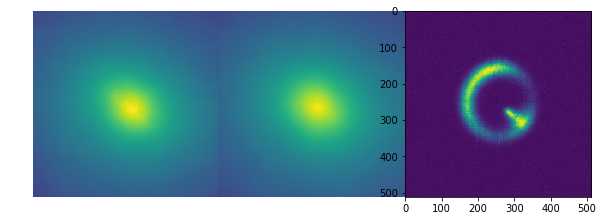

3890
3891
3892
3893


KeyboardInterrupt: 

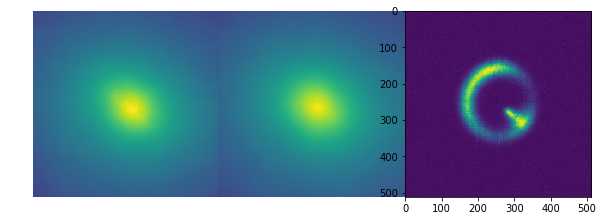

In [89]:
for train_iter in range(10000):
    print train_iter
    sk_gen.draw_k_s("train")

    normalizations = tf.tile(tf.random_uniform(shape=[train_batch_size,1,1],minval=3.1, maxval=3.2),(1,npix_side,npix_side))
    tf_logkappa = tf.reshape(log10(normalizations * VAE_obj_master.draw_image(train_batch_size)) , (-1,npix_side,npix_side,1) )
    #tf_logkappa = tf.reshape(log10(VAE_obj_learner.draw_image(train_batch_size)) , (-1,npix_side,npix_side,1) )

    
    tf_source =  tf.identity(sk_gen.Source_tr[:,:,:,:])
    #tf_logkappa  = tf.identity( np.log10(sk_gen.Kappa_tr[:,:,:,:] ) ) 
    noisy_data = lens_util_obj.simulate_noisy_lensed_image(  tf_source, tf_logkappa ,noise_rms)

    FFCNN_obj.train( noisy_data , tf_logkappa, optimizer)

    if (((train_iter+1)%10)==0):
        output = FFCNN_obj.fullforward_pass(noisy_data)
        pl.clf()
        fig, ax = pl.subplots(1, 3, figsize = (10, 15))
        pl.subplots_adjust(wspace = 0, hspace = 0)
        imsrcP = ax[0].imshow(tf_logkappa[0,:,:,0])

        imsrcT = ax[1].imshow(output[0,:,:].numpy())
        imsrcT = ax[2].imshow(noisy_data[0,:,:,0].numpy())
        ax[0].axis('off')
        ax[1].axis('off')
        display.clear_output(wait=True)
        display.display(pl.gcf())
    if (((train_iter+1)%100)==0):
        FFCNN_obj.Save()
        print "saved"



